In [2]:
import cvxpy as cp
from scipy.special import roots_sh_legendre
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Word:
    def __init__(self, word: str):
        self._word = word
    def __repr__(self):
        return repr(self._word)
    def H(self):
        return Word(self._word[::-1])
    def __hash__(self):
        return hash(self._word)
    def __eq__(self, other):
        if not isinstance(other, Word):
            return False
        return self._word == other._word

class Basis:
    def __init__(self, ops: list[str]):
        self._ops = ops
        self._mapping = {op: i for i, op in enumerate(ops)}
        self._sz = len(ops)
    
    def rank(self, word: Word|str):
        if isinstance(word, Word):
            word = word._word
        v = self._sz ** (len(word)) - 1
        for i, op in enumerate(reversed(word)):
            v += self._mapping[op] * (self._sz ** i)
        return v

    def unrank(self, pos: int):
        len = 0
        while self._sz ** len - 1 <= pos:
            len += 1
        len -= 1
        pos -= self._sz ** len - 1
        word = [None] * len
        for i in range(len):
            word[i] = self._ops[pos % self._sz]
            pos //= self._sz
        return ''.join(word[::-1])

def commutator(word1: str, word2: str):
    expression = []
    for i in range(len(word1)):
        for j in range(len(word2)):
            # 1 2 2 1
            word = word1[:i] + word2[:j] + word2[j+1:] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression.append('+' + word)
            elif word1[i] == 'p' and word2[j] == 'x':
                expression.append('-' + word)
    return expression

<h2>Thermal anharmonic oscillator:</h2>

In [4]:
def canonical_relation(basis: Basis, B, word1: str, word2: str):
    t1 = Word(word1 + 'xp' + word2)
    t2 = Word(word1 + 'px' + word2)
    t3 = Word(word1 + word2)
    return [B[basis.rank(t1)] - B[basis.rank(t2)] == 1j * B[basis.rank(t3)]]

def schwinger_dyson(basis: Basis, B, hamil: list, word1: str):
    expression = 0
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for term in terms:
            if term[0] == '+':
                expression = expression + coeff * B[basis.rank(term[1:])]
            else:
                expression = expression - coeff * B[basis.rank(term[1:])]
    return [expression == 0]

def normalization(B):
    return [B[0] == 1]

def reality(basis: Basis, B, word: str):
    return [B[basis.rank(word[::-1])] == cp.conj(B[basis.rank(word)])]

def thermal_density_matrix(basis: Basis, B, L):
    n = 2 ** (L//2 + 1) - 1
    M = cp.bmat([[B[basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))] for j in range(n)] for i in range(n)])
    return [M >> 0]

In [49]:
def beta_independent_constraints(basis, B, L, hamil):
    constraints = []
    constraints.extend(thermal_density_matrix(basis, B, L))
    constraints.extend(normalization(B))
    for i in range(2 ** (L - 1) - 1):
        for j in range(2 ** (L - 1) - 1):
            if len(basis.unrank(i) + basis.unrank(j)) > L - 2:
                continue
            constraints.extend(canonical_relation(basis, B, basis.unrank(i), basis.unrank(j)))
    for i in range(2 ** (L + 1) - 1):
            constraints.extend(reality(basis, B, basis.unrank(i)))
    return constraints

def beta_independent_kms_constraints(basis, H, L, m, k, hamil):
    n = 2 ** (L // 2) - 1
    constraints = []
    A = cp.bmat([[H[basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))] for j in range(n)] for i in range(n)])
    B = cp.bmat([[H[basis.rank(basis.unrank(j) + basis.unrank(i)[::-1])] for j in range(n)] for i in range(n)])
    Ts = [cp.Variable((n,n),f'T_{i}',hermitian=True) for i in range(1, m + 1)]
    Zs = [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(0, k + 1)]
    constraints.append(Zs[0] == B)
    ts, _ = roots_sh_legendre(m)
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    for j in range(m):
        constraints.append(cp.bmat([[Zs[k] - A - Ts[j], -np.sqrt(ts[j]) * Ts[j]],
                                    [-np.sqrt(ts[j]) * Ts[j], A - ts[j] * Ts[j]]]) >> 0)
    def get_term(i, j):
        expression = 0
        for coeff, w in hamil:
            terms = commutator(w, basis.unrank(j))
            for term in terms:
                if term[0] == '+':
                    expression = expression + coeff * H[basis.rank(basis.unrank(i)[::-1] + term[1:])]
                else:
                    expression = expression - coeff * H[basis.rank(basis.unrank(i)[::-1] + term[1:])]
        return 1j * expression
    C = cp.bmat([[get_term(i, j) for j in range(n)] for i in range(n)])
    return Ts, C, constraints

def beta_dependent_kms_constraints(Ts, C, m, k, beta):
    constraints = []
    _, ws = roots_sh_legendre(m)
    constraints.append(sum(wj * Tj for wj,Tj in zip(ws, Ts)) == -2**(-k) * beta * C)
    return constraints

def solver(basis, B, constraints, Ts, C, m, k, beta):
    kms_constraints = beta_dependent_kms_constraints(Ts, C, m, k, beta)
    energy = cp.real(B[basis.rank('pp')] + B[basis.rank('xxxx')])
    minprob = cp.Problem(cp.Minimize(energy), constraints + kms_constraints)
    E_min = minprob.solve(accept_unknown=True)
    maxprob = cp.Problem(cp.Maximize(energy), constraints + kms_constraints)
    E_max = maxprob.solve(accept_unknown=True)
    return E_min, E_max

In [51]:
def solve_energy(betas, L, m, k):
    basis = Basis(['x','p'])
    hamil = [(1, 'pp'), (1, 'xxxx')]
    from itertools import product
    op_basis = [''.join(op)
                for i in range(L + 1)
                for op in product(['x','p'],repeat=i)]
    B = [cp.Variable(1, op, complex=True) for op in op_basis]
    constraints = beta_independent_constraints(basis, B, L, hamil)
    Ts, C, extra_constraints = beta_independent_kms_constraints(basis, B, L, m, k, hamil)
    constraints.extend(extra_constraints)
    mins,maxs = [], []
    for beta in betas:
        print(f'Solving for T={1/beta}:')
        E_min, E_max = solver(basis, B, constraints, Ts, C, m, k, beta)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins.append(E_min)
        maxs.append(E_max)
    return mins, maxs

In [52]:
betas = 1/np.linspace(0.1,0.6,num=6)
mins22, maxs22 = solve_energy(betas, 8, 2, 2)
mins44, maxs44 = solve_energy(betas, 8, 4, 4)

Solving for T=0.1:
	E_min = 1.0603622370340386
	E_max = 1.0603624521723432
Solving for T=0.2:
	E_min = 1.0603632144039323
	E_max = 1.0603655535734262
Solving for T=0.30000000000000004:
	E_min = 1.0604464578400101
	E_max = 1.0604883906827605
Solving for T=0.4:
	E_min = 1.0625224697984699
	E_max = 1.0628274824933084
Solving for T=0.5:
	E_min = 1.0705847697057878
	E_max = 1.0715602087296916
Solving for T=0.6:
	E_min = 1.0872051469498138
	E_max = 1.0892787172063487
Solving for T=0.1:
	E_min = 1.0603622138588058
	E_max = 1.0603629466709794
Solving for T=0.2:
	E_min = 1.0603649543296918
	E_max = 1.0603751684245548
Solving for T=0.30000000000000004:
	E_min = 1.0606496399057002
	E_max = 1.060708240575015
Solving for T=0.4:
	E_min = 1.0632128506488563
	E_max = 1.063545441297178
Solving for T=0.5:
	E_min = 1.0715885935658997
	E_max = 1.0725841021975484
Solving for T=0.6:
	E_min = 1.0882780746369016
	E_max = 1.0903747956279188


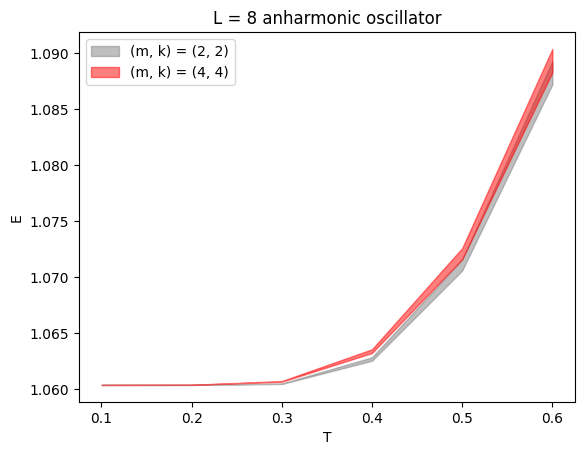

In [53]:
plt.fill_between(1/betas, mins22, maxs22, alpha = 0.5, color='grey', label='(m, k) = (2, 2)')
plt.fill_between(1/betas, mins44, maxs44, alpha = 0.5, color='red', label='(m, k) = (4, 4)')
plt.xlabel('T')
plt.ylabel('E')
plt.title('L = 8 anharmonic oscillator')
plt.legend()
plt.show()